In [33]:
# Pacotes básicos
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Pacotes do Scikit-learn para acesso a datasets, preparação, modelagem e avaliação
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Pacotes para modelos de aprendizado
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

# Pacote de balanceamento de classes desbalanceadas
# from imblearn.over_sampling import SMOTE

from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder, MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, recall_score, f1_score, roc_curve, roc_auc_score, auc

In [34]:
def splitfeatures(X):
  X_num=X.describe().columns
  X_cat=X.columns.difference(X_num)
  X_num=X_num.tolist()
  X_cat=X_cat.tolist()
  print("Numeric features:      ",X_num)
  print("Categorical features:  ",X_cat)

def numfeatures(X):
    return(X.describe().columns.tolist())

def catfeatures(X):
    X_num=X.describe().columns
    return(X.columns.difference(X_num).tolist())

def plot_distribution( df , var , target , **kwargs ):
    row = kwargs.get( 'row' , None )
    col = kwargs.get( 'col' , None )
    facet = sns.FacetGrid( df , hue=target , aspect=4 , row = row , col = col )
    facet.map( sns.kdeplot , var , shade= True )
    facet.set( xlim=( 0 , df[ var ].max() ) )
    facet.add_legend()
    
def plot_categories( df , cat , target , **kwargs ):
    row = kwargs.get( 'row' , None )
    col = kwargs.get( 'col' , None )
    facet = sns.FacetGrid( df , row = row , col = col )
    facet.map( sns.barplot , cat , target )
    facet.add_legend()
    
def missing_percentage(df):
    total = df.isnull().sum().sort_values(ascending = False)
    percent = round(df.isnull().sum().sort_values(ascending = False)/len(df)*100,2)
    return pd.concat([total, percent], axis=1, keys=['Total','Percent'])

def percent_value_counts(df, feature):
    percent = pd.DataFrame(round(df.loc[:,feature].value_counts(dropna=False, normalize=True)*100,2))
    total = pd.DataFrame(df.loc[:,feature].value_counts(dropna=False))
    total.columns = ["Total"]
    percent.columns = ['Percent']
    return pd.concat([total, percent], axis = 1)

def unique_values_in_column(data,feature):
    unique_val=pd.Series(data.loc[:,feature].unique())
    return pd.concat([unique_val],axis=1,keys=['Unique Values'])

In [35]:
df = pd.read_csv("treino.csv")
# Informações gerais do dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 16 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   IDpassageiro   1000 non-null   object
 1   Nome           1000 non-null   object
 2   Deck           1000 non-null   object
 3   NumeroCabine   1000 non-null   int64 
 4   PosicaoCabine  1000 non-null   object
 5   Procedencia    1000 non-null   object
 6   Destino        1000 non-null   object
 7   Idade          1000 non-null   int64 
 8   VIP            1000 non-null   bool  
 9   AllInclusive   1000 non-null   bool  
 10  ServicoCabine  1000 non-null   int64 
 11  Restaurante    1000 non-null   int64 
 12  Shopping       1000 non-null   int64 
 13  SPA            1000 non-null   int64 
 14  ParquedeAguas  1000 non-null   int64 
 15  Sobrevivente   1000 non-null   bool  
dtypes: bool(3), int64(7), object(6)
memory usage: 104.6+ KB


In [36]:
df.sample(10)

,IDpassageiro,Nome,Deck,NumeroCabine,PosicaoCabine,Procedencia,Destino,Idade,VIP,AllInclusive,ServicoCabine,Restaurante,Shopping,SPA,ParquedeAguas,Sobrevivente
267,3474_01,Weias Pasharne,F,517,S,China,France,48,False,False,400,886,5268,1263,170,True
181,6920_01,Verek Wolferguson,G,141,P,Vietnam,Chile,59,True,True,1712,547,8212,1050,393,False
540,0982_01,Eriky Hewson,H,1031,S,Tanzania,Greece,17,True,False,387,1171,5100,2675,434,False
779,5744_01,Felice Hinglendez,C,1264,S,Portugal,China,6,False,False,353,1296,10153,2730,430,False
695,1826_01,Mollen Lewintos,H,190,P,Indonesia,Indonesia,34,False,False,212,56,2304,1544,690,False
404,4973_01,Paulie Stephendsey,C,1299,P,China,China,1,False,False,1289,850,6285,2005,339,True
469,2591_01,Adammy Coolerson,G,1306,P,Lithuania,Indonesia,12,False,True,1614,1294,5620,1318,341,False
490,2006_03,Joana Moorez,H,210,S,Poland,Sweden,5,False,False,442,1240,12282,2935,453,True
728,0011_01,Elle Bertsontry,F,144,S,El Salvador,Ireland,30,True,True,1123,428,9471,1326,256,False
682,6360_02,Glueba Clumsty,F,230,S,China,Poland,7,False,False,1285,755,8117,1189,74,False


- IDpassageiro – identificação única por passageiro, na forma XXXX_YY, onde XXXX é o número do grupo (tipicamente 
família) e YY é o número do integrante no grupo;
- Nome – nome do passageiro (fictício)
- Deck, NumeroCabine e PosicaoCabine – identificação da cabine ocupada por deck, número e posição (se é do lado que o 
navio ancora nos portos (P) ou o lado oposto (S));
- Procedência – de onde veio o passageiro ao embarcar: de algum país da Europa, da América, da África ou de outro lugar;
- Destino – porto de desembarque do passageiro;
- Idade – idade do passageiro;
- VIP – se o passageiro adquiriu o pacote VIP;
- AllInclusive – se o passageiro optou pela modalidade de hospedagem all inclusive (tudo incluído);
- ServicoCabine, Restaurante, Shopping, SPA e ParquedeAguas – quanto o passageiro já dispendeu nesses serviços;
- Sobrevivente – atributo classe: anotação sobre se o passageiro sobreviveu, ou não, ao naufrágio

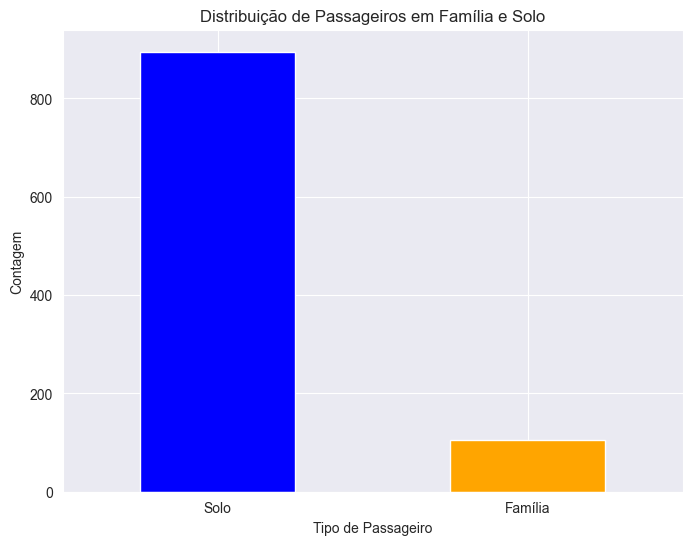

In [37]:
# Passo 1: Separar o ID de grupo e o número do integrante
df[['Grupo', 'Integrante']] = df['IDpassageiro'].str.split('_', expand=True)

# Passo 2: Identificar se o passageiro está em família
# Contar a quantidade de passageiros por grupo
group_counts = df['Grupo'].value_counts()
# Se o grupo tiver mais de um integrante, marcar como família
df['EmFamilia'] = df['Grupo'].apply(lambda x: 1 if group_counts[x] > 1 else 0)

# Passo 3: Criar gráficos
# Gráfico de barras para visualizar passageiros em família ou não
plt.figure(figsize=(8, 6))
df['EmFamilia'].value_counts().plot(kind='bar', color=['blue', 'orange'])
plt.xticks(ticks=[0, 1], labels=['Solo', 'Família'], rotation=0)
plt.title('Distribuição de Passageiros em Família e Solo')
plt.xlabel('Tipo de Passageiro')
plt.ylabel('Contagem')
plt.show()

In [38]:
df = df.drop(columns=['IDpassageiro', 'Nome', 'Procedencia', 'Destino'])
df

,Deck,NumeroCabine,PosicaoCabine,Idade,VIP,AllInclusive,ServicoCabine,Restaurante,Shopping,SPA,ParquedeAguas,Sobrevivente,Grupo,Integrante,EmFamilia
0,D,193,P,61,False,True,239,1288,3380,1158,587,True,5647,02,0
1,A,1202,S,31,True,False,466,6,11299,1598,506,True,0107,01,0
2,G,107,P,49,True,True,1240,674,10989,806,463,True,4158,01,0
3,G,545,S,32,False,True,176,1186,8750,1438,379,True,1316,01,0
4,D,392,P,5,False,False,90,1318,161,2853,203,True,9069,05,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,G,1310,S,61,True,True,1569,106,8090,2915,680,True,6802,01,0
996,G,1165,P,48,False,True,1455,70,8001,2858,361,True,0313,01,0
997,E,520,P,41,False,False,471,841,11890,100,437,True,9094,01,0
998,C,167,P,75,False,True,1072,1133,13953,1355,384,False,6594,01,0


In [39]:
# Agrupar os dados pelo número do grupo e contar o número de cabines únicas por grupo
grupo_cabine = df.groupby('Grupo')['NumeroCabine'].nunique().reset_index()

# Renomear as colunas para facilitar a interpretação
grupo_cabine.columns = ['Grupo', 'Cabines_Uniquas']

# Exibir os primeiros resultados
print(grupo_cabine.head(10))

# Verificar quantos grupos têm mais de uma cabine
grupos_multiplas_cabines = grupo_cabine[grupo_cabine['Cabines_Uniquas'] > 1]
print(f"Número de grupos com múltiplas cabines: {len(grupos_multiplas_cabines)}")

# Exibir uma amostra dos grupos com múltiplas cabines, se houver
print(grupos_multiplas_cabines.head(10))


  Grupo  Cabines_Uniquas
0  0001                1
1  0007                1
2  0011                1
3  0024                1
4  0031                1
5  0067                2
6  0086                1
7  0099                1
8  0103                1
9  0107                1
Número de grupos com múltiplas cabines: 50
    Grupo  Cabines_Uniquas
5    0067                2
55   0482                2
61   0512                2
76   0618                2
77   0619                2
91   0789                2
94   0863                2
111  1024                2
133  1304                2
139  1353                2


In [40]:
# Codificação de Deck usando Label Encoding
df['Deck'] = df['Deck'].astype('category').cat.codes

# Codificação de PosicaoCabine (P = 1, S = 0)
df['PosicaoCabine'] = df['PosicaoCabine'].map({'P': 1, 'S': 0})
df.head(10)

,Deck,NumeroCabine,PosicaoCabine,Idade,VIP,AllInclusive,ServicoCabine,Restaurante,Shopping,SPA,ParquedeAguas,Sobrevivente,Grupo,Integrante,EmFamilia
0,3,193,1,61,False,True,239,1288,3380,1158,587,True,5647,02,0
1,0,1202,0,31,True,False,466,6,11299,1598,506,True,0107,01,0
2,6,107,1,49,True,True,1240,674,10989,806,463,True,4158,01,0
3,6,545,0,32,False,True,176,1186,8750,1438,379,True,1316,01,0
4,3,392,1,5,False,False,90,1318,161,2853,203,True,9069,05,0
5,1,852,1,72,False,True,1548,979,5356,1648,480,True,6756,02,0
6,2,1150,0,69,True,True,603,792,13718,2869,364,False,8056,02,1
7,7,358,0,5,True,False,84,873,3754,1110,357,True,2993,01,0
8,4,710,0,47,True,True,420,634,8517,423,487,True,4564,01,0
9,2,877,0,6,False,False,1360,16,13964,525,282,False,0600,01,0
